In [35]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

In [36]:
# problem domain
def y(x,E,w,I,a):
    return w*x**2*(a-x)**2/(24*E*I)
#Parameters
E=127e9
t=0.000935
b=50e-3
I=b*t**3/12
a=0.027487
L=a
rng = np.random.default_rng(seed=42)
x=rng.uniform(0, L, 1000)
x_train = x
q=860210.526316
y_train = y(x_train,E,q,I,L)

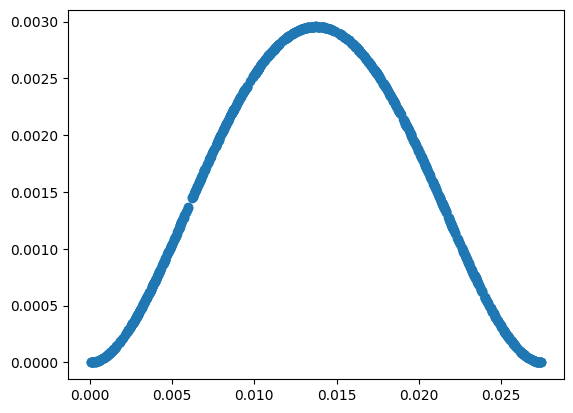

In [37]:
plt.plot(x_train, y_train, 'o')

In [38]:
#Scale data
x_max=x_train.max()
y_max=y_train.max()
x_scaled = x_train / x_max
y_scaled = y_train / y_max


In [39]:
# NN architecture / training
hidden_layers = [50, 50, 50, 50]
activation = nn.Tanh  

In [40]:
# ====== MLP builder ======
def build_mlp(input_dim, output_dim, hidden_layers, act=nn.Tanh):
    layers = []
    prev = input_dim
    for h in hidden_layers:
        layers.append(nn.Linear(prev, h))
        layers.append(act())
        prev = h
    layers.append(nn.Linear(prev, output_dim))
    return nn.Sequential(*layers)
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization

# ====== redes separadas para w, theta, M, Q ======
w_net = build_mlp(1, 1, hidden_layers, act=activation)
theta_net = build_mlp(1, 1, hidden_layers, act=activation)
M_net = build_mlp(1, 1, hidden_layers, act=activation)
Q_net = build_mlp(1, 1, hidden_layers, act=activation) #Q tiene 2 salidas (Q y q)
q_net = build_mlp(1, 1, hidden_layers, act=activation)
init_xavier(w_net, retrain)
init_xavier(theta_net, retrain)
init_xavier(M_net, retrain)
init_xavier(Q_net, retrain)
init_xavier(q_net, retrain)
nets = [w_net, theta_net, M_net, Q_net, q_net]

In [41]:
seed = 1234
lr = 1e-3
torch.manual_seed(seed)
np.random.seed(seed)

In [42]:
# ====== derivative function ======
def deriv(y, x, order=1):
    # y: tensor scalar output; x: tensor inputs (requires_grad=True)
    assert x.requires_grad, "x must require_grad"
    out = y
    for i in range(order):
        grads = autograd.grad(outputs=out, inputs=x,
                              grad_outputs=torch.ones_like(out),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
        out = grads
    return out

In [43]:
x_coll = torch.tensor(x_scaled.astype(np.float32),dtype=torch.float32, requires_grad=True).reshape(-1,1)
#Boundary points
x_b0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True).reshape(-1,1)
x_bL = torch.tensor([[1.0]], dtype=torch.float32, requires_grad=True).reshape(-1,1)


In [44]:
def pinn_loss(nets, x_in, x_b0, x_bL,y_true):
    w_pred = nets[0](x_in).reshape(-1,1)          # w(x)
    theta_pred = nets[1](x_in).reshape(-1,1)      # theta(x)
    M_pred = nets[2](x_in).reshape(-1,1)          # M(x)
    Q_pred = nets[3](x_in).reshape(-1,1)          # Q(x)

    dw_dx = deriv(w_pred, x_in, order=1)
    Lw = dw_dx - theta_pred #First equation

    dtheta_dx = deriv(theta_pred, x_in, order=1)
    Ltheta = dtheta_dx + M_pred #Second equation
    
    # dM/dx + Q = 0  => L_M
    dM_dx = deriv(M_pred, x_in, order=1)
    LM = dM_dx + Q_pred #Third equation


    dQ_dx = deriv(Q_pred, x_in, order=1)
    q_vals = nets[4](x_in).reshape(-1,1)   # Optimize parameter
    LQ = dQ_dx + q_vals #Fourth equation

    # PDE residual norms (MSE)
    loss_w = torch.mean(Lw**2)
    loss_theta = torch.mean(Ltheta**2)
    loss_M = torch.mean(LM**2)
    loss_Q = torch.mean(LQ**2)
    # Boundary conditions w(0)=0, w(L)=0, theta(0)=0, theta(L)=0
    w_b0_pred = nets[0](x_b0)
    w_bL_pred = nets[0](x_bL)
    theta_b0_pred = nets[1](x_b0)
    theta_bL_pred = nets[1](x_bL)

    loss_bcs= torch.mean(w_b0_pred**2) + torch.mean(w_bL_pred**2) + \
                torch.mean(theta_b0_pred**2) + torch.mean(theta_bL_pred**2)
    loss_mse= torch.mean((w_pred - y_true)**2)
    total = loss_w + loss_theta + loss_M + loss_Q + loss_bcs + loss_mse
    return total, dict(loss_w=loss_w.item(), loss_theta=loss_theta.item(),
                       loss_M=loss_M.item(), loss_Q=loss_Q.item(), loss_bcs=loss_bcs.item(), loss_mse=loss_mse.item(),dQ_dx=dQ_dx.mean().item())

In [45]:
#Preentreno con Adam
n_epochs = 200
use_lbfgs = False
params = []
for net in nets:
    params += list(net.parameters())

optimizer = torch.optim.Adam(params, lr=lr)
if use_lbfgs:
    lbfgs_optimizer = torch.optim.LBFGS(params, max_iter=500, tolerance_grad=1e-9, tolerance_change=1e-12, history_size=50)
loss_history = []
loss_mse_history = []
loss_bd=[]
loss_pde=[]
q_vals_history=[]
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()
    y_true=torch.tensor(y_scaled.astype(np.float32),dtype=torch.float32).reshape(-1,1)
    total_loss, comp = pinn_loss(nets, x_coll, x_b0, x_bL, y_true)
    total_loss.backward()
    optimizer.step()

    loss_history.append(total_loss.item())
    loss_mse_history.append(comp['loss_mse'])
    loss_bd.append(comp['loss_bcs'])
    loss_pde.append(comp['loss_w'] + comp['loss_theta'] + comp['loss_M'] + comp['loss_Q'])
    q_vals_history.append(nets[4](x_coll).mean().item())


    if epoch % 100 == 0 or epoch == 1:
        print(f"Epoch {epoch:6d} | Loss {total_loss.item():.3e} | components: {comp}")


Epoch      1 | Loss 5.432e-01 | components: {'loss_w': 0.008555391803383827, 'loss_theta': 0.027205344289541245, 'loss_M': 0.027205344289541245, 'loss_Q': 0.027205344289541245, 'loss_bcs': 0.018401194363832474, 'loss_mse': 0.4345962405204773, 'dQ_dx': -0.09763791412115097}
Epoch    100 | Loss 2.814e-01 | components: {'loss_w': 0.01785208284854889, 'loss_theta': 0.0004322175809647888, 'loss_M': 0.00010208887397311628, 'loss_Q': 4.286239345674403e-05, 'loss_bcs': 0.054642170667648315, 'loss_mse': 0.2083493024110794, 'dQ_dx': -0.01187126338481903}
Epoch    200 | Loss 2.811e-01 | components: {'loss_w': 0.018154656514525414, 'loss_theta': 0.0003783058491535485, 'loss_M': 2.2406293282983825e-05, 'loss_Q': 7.586746960441815e-06, 'loss_bcs': 0.05405614897608757, 'loss_mse': 0.20851022005081177, 'dQ_dx': 0.051561761647462845}


In [46]:

# ====== optimizer LBFGS ======
lbfgs_optimizer = torch.optim.LBFGS(params, max_iter=10, tolerance_grad=1e-9, tolerance_change=1e-12, history_size=50)
n_epochs = 2000
for epoch in range(1, n_epochs + 1):
    def closure():
        lbfgs_optimizer.zero_grad()
        loss_lb, _ = pinn_loss(nets, x_coll, x_b0, x_bL,y_true)
        loss_lb.backward()
        return loss_lb
    
    lbfgs_optimizer.step(closure)
    total_loss, comp = pinn_loss(nets, x_coll, x_b0, x_bL,y_true)
    if epoch % 100 == 0 or epoch == 1:
        print("  --> Running L-BFGS refinement ...")
        print(f"Epoch {epoch:6d} | Loss {total_loss.item():.3e} | components: {comp}")
    loss_history.append(total_loss.item())
    loss_mse_history.append(comp['loss_mse'])
    loss_bd.append(comp['loss_bcs'])
    loss_pde.append(comp['loss_w'] + comp['loss_theta'] + comp['loss_M'] + comp['loss_Q'])
    q_vals_history.append(nets[4](x_coll).mean().item())


  --> Running L-BFGS refinement ...
Epoch      1 | Loss 2.810e-01 | components: {'loss_w': 0.017731599509716034, 'loss_theta': 0.0004819656314793974, 'loss_M': 3.616794856498018e-05, 'loss_Q': 3.891872620442882e-05, 'loss_bcs': 0.0543634407222271, 'loss_mse': 0.2083694487810135, 'dQ_dx': 0.15677355229854584}
  --> Running L-BFGS refinement ...
Epoch    100 | Loss 1.959e-01 | components: {'loss_w': 0.013270445168018341, 'loss_theta': 0.0009776100050657988, 'loss_M': 0.0012046439805999398, 'loss_Q': 0.0005913904751650989, 'loss_bcs': 0.03639610856771469, 'loss_mse': 0.14347559213638306, 'dQ_dx': 63.6865234375}
  --> Running L-BFGS refinement ...
Epoch    200 | Loss 1.354e-01 | components: {'loss_w': 0.008871094323694706, 'loss_theta': 0.000756261870265007, 'loss_M': 0.0012503776233643293, 'loss_Q': 0.0013363814214244485, 'loss_bcs': 0.025786831974983215, 'loss_mse': 0.0973748192191124, 'dQ_dx': 117.4354476928711}
  --> Running L-BFGS refinement ...
Epoch    300 | Loss 1.086e-01 | compone

In [47]:
E,-q,I,L

(127000000000.0, -860210.526316, 3.405834895833333e-12, 0.027487)

In [48]:
def d_f(x,f):
    h=x[1]-x[0]
    df=[]
    for i in range(len(x)):
        if i==len(x)-1:
            break
        dfi=(f[i+1]-f[i])/h
        
        df.append(dfi)
    return np.array(df)

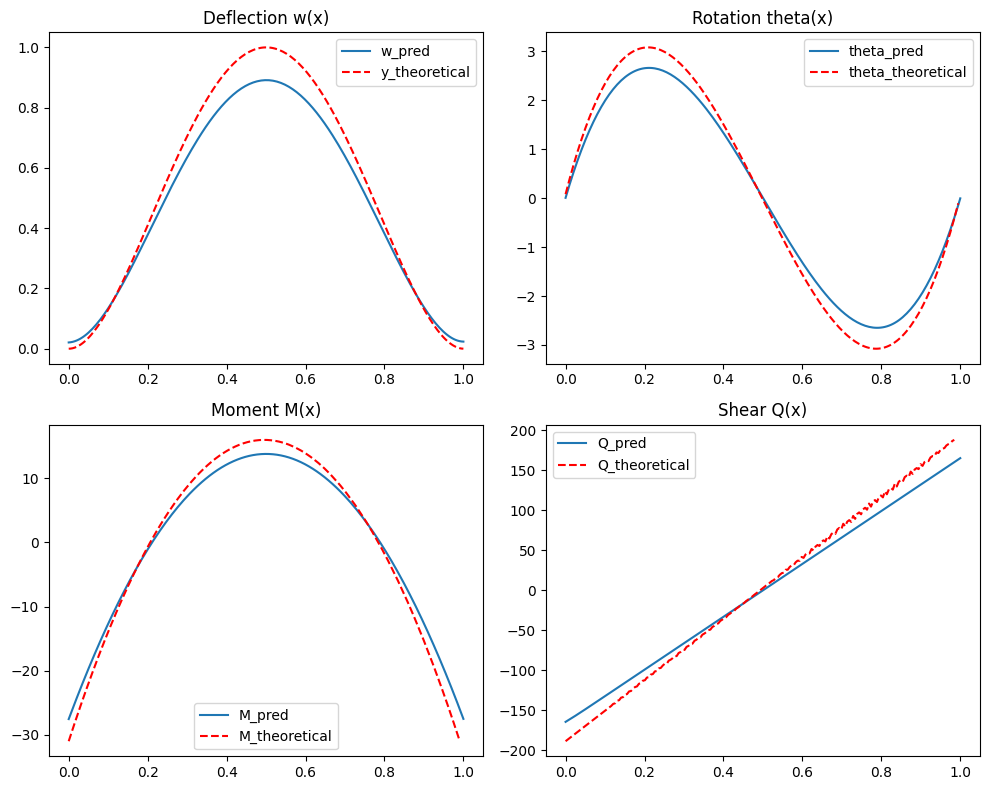

In [49]:
# ====== Results: evaluate on dense grid and plot ======
x_plot = torch.tensor(np.linspace(0, 1, 200).reshape(-1,1).astype(np.float32), requires_grad=True)
with torch.no_grad():
    w_pred_plot = w_net(x_plot).cpu().numpy().flatten()
    theta_pred_plot = theta_net(x_plot).cpu().numpy().flatten()
    M_pred_plot = M_net(x_plot).cpu().numpy().flatten()
    Q_pred_plot = Q_net(x_plot)[:,0].cpu().numpy().flatten()
x_np = x_plot.cpu().detach().numpy()
x_np=x_np*x_max # Scale back to original domain
w_pred_plot=w_pred_plot # Scale back to original domain
y_true_plot = y(x_np,E,q,I,L)/y_max
x_np=x_np/x_max 
theta_true_plot = d_f(x_np,y_true_plot)
M_true_plot = -d_f(x_np[:-1],theta_true_plot)
Q_true_plot = -d_f(x_np[:-2],M_true_plot)

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(x_np, w_pred_plot, label='w_pred')
plt.plot(x_np, y_true_plot, 'r--', label='y_theoretical')
plt.title('Deflection w(x)')
plt.legend()
plt.subplot(2,2,2)
plt.plot(x_np, theta_pred_plot, label='theta_pred')
plt.plot(x_np[:-1], theta_true_plot, 'r--', label='theta_theoretical')
plt.title('Rotation theta(x)')

plt.legend()
plt.subplot(2,2,3)
plt.plot(x_np, M_pred_plot, label='M_pred')
plt.plot(x_np[:-2],M_true_plot, 'r--', label='M_theoretical')
plt.title('Moment M(x)')
plt.legend()
plt.subplot(2,2,4)
plt.plot(x_np[:], Q_pred_plot, label='Q_pred')
plt.plot(x_np[:-3], Q_true_plot, 'r--', label='Q_theoretical')

plt.title('Shear Q(x)')
plt.legend()
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Training Loss History')

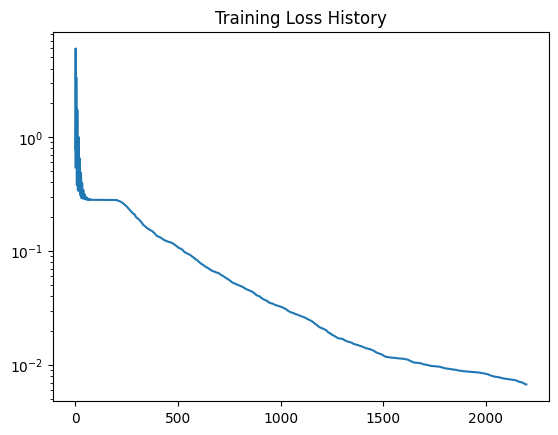

In [50]:
plt.semilogy(loss_history)
plt.title('Training Loss History')

Text(0.5, 1.0, 'Loss Components History')

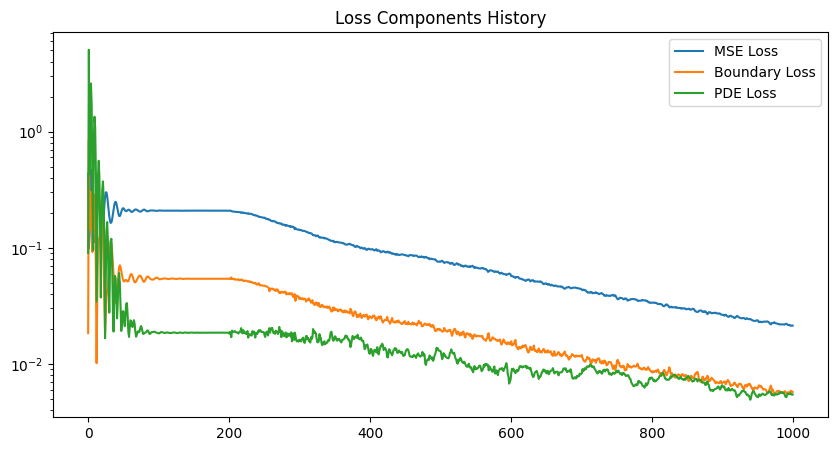

In [51]:
#loss plots
plt.figure(figsize=(10,5))
plt.semilogy(loss_mse_history[:1000], label='MSE Loss')
plt.semilogy(loss_bd[:1000], label='Boundary Loss')
plt.semilogy(loss_pde[:1000], label='PDE Loss')
plt.legend()
plt.title('Loss Components History')


